# Self-Contained Source Separation

## Setup

First let's import libraries and create some convenience functions for our neural network operations with sane default values.

Unfortunately there isn't an easy way to hide code blocks in jupyter, so just skip over this :)

In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
from functools import partial
import numpy as np
import librosa
import pycochleagram.cochleagram as cgram

plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['image.cmap'] = 'hot'

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\Program Files\Anaconda3\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
C:\Program Files\Anaconda3\lib\site-packages\pycochleagram-0.1-py3.6.egg\pycochleagram\erbfilter.py:8: RuntimeWarning: pycochleagram using non-interactive Agg matplotlib backend
  from pycochleagram import utils


In [2]:
def concat(x, y):
    return tf.concat([x, y], axis=3)


def conv(inputs, filters, kernel_size, stride):
    out = tf.layers.conv2d(
        inputs, filters=filters, kernel_size=kernel_size,
        kernel_initializer=tf.random_normal_initializer(stddev=0.02),
        strides=stride, padding='SAME')

    return out


def deconv(inputs, filters, kernel_size, stride):
    out = tf.layers.conv2d_transpose(
        inputs, filters=filters, kernel_size=kernel_size,
        kernel_initializer=tf.random_normal_initializer(stddev=0.02),
        strides=stride, padding='SAME')

    return out


def batch_norm(inputs, is_training, reuse):
    return tf.contrib.layers.batch_norm(
        inputs,
        decay=0.9,
        updates_collections=None,
        epsilon=1e-5,
        scale=True,
        is_training=is_training,
        reuse=reuse)


def dropout(inputs, rate):
    return tf.nn.dropout(inputs, keep_prob=1 - rate)


def relu(inputs):
    return tf.nn.relu(inputs)


def tanh(inputs):
    return tf.nn.tanh(inputs)


def lrelu(x, leak=0.2):
    with tf.variable_scope('lrelu'):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)


def l1_loss(x, y):
    return tf.reduce_mean(tf.abs(x - y))

def pw_l1_loss(x, y):
    return tf.abs(x - y)

def read_audio(path, sample_rate, n_channels):

    def read_audio_py(py_path):
        #if n_channels == 1:
            mono, _ = librosa.load(py_path, sr=sample_rate, mono=True)
            return np.expand_dims(mono, 1)
        #elif n_channels == 2:
            #stereo, _ = librosa.load(py_path, sr=sample_rate, mono=False)
            #return stereo.T
        #else:
            #raise ValueError('Invalid channels: %d' % n_channels)

    return tf.py_func(read_audio_py, [path], tf.float32, stateful=False)


def fake_stereo(audio):

    def fake_stereo(x):
        return tf.stack([x, x], 1)
    
    voice = audio[:, 0]
    mixed = voice * 2
    return fake_stereo(mixed), fake_stereo(voice)


def compute_spectrogram(audio, n_fft, fft_hop, n_channels):
    '''
    Parameters
    ----------
    audio : single to dual channel audio shaped (n_samples, n_channels)

    Returns
    -------
    Tensor of shape (n_frames, 1 + n_fft / 2, n_channels * 2), where the
        last dimension is (left_mag, right_mag, left_phase, right_phase)
    '''

    def stft(x):
        spec = librosa.stft(
            x, n_fft=n_fft, hop_length=fft_hop, window='hann')
        # TODO: normalize?
        #mag = np.abs(spec)
        #temp = mag - mag.min()
        #mag_norm = temp / temp.max()
        return np.abs(spec), np.angle(spec)

    #def stereo_func(py_audio):
    #    left_mag, left_phase = stft(py_audio[:, 0])
    #    right_mag, right_phase = stft(py_audio[:, 1])
    #    ret = np.array([left_mag, right_mag, left_phase, right_phase]).T
    #    return ret.astype(np.float32)

    def mono_func(py_audio):
        mag, phase = stft(py_audio[:, 0])
        ret = np.array([mag, phase]).T
        return ret.astype(np.float32)

    #if n_channels == 2:
    #    func = stereo_func
    #elif n_channels == 1:
    #    func = mono_func
    #else:
    #    raise ValueError('Invalid channels: %d' % n_channels)

    with tf.name_scope('read_spectrogram'):
        ret = tf.py_func(mono_func, [audio], tf.float32, stateful=False)
        ret.set_shape([None, 1 + n_fft / 2, 2])   # n_channels * 2])
    return ret


def extract_spectrogram_patches(
        spec, n_fft, n_channels, patch_window, patch_hop):
    '''
    Parameters
    ----------
    spec : Spectrogram of shape (n_frames, 1 + n_fft / 2, n_channels * 2)

    Returns
    -------
    Tensor of shape (n_patches, patch_window, 1 + n_fft / 2, n_channels * 2)
        containing patches from spec.
    '''
    with tf.name_scope('extract_spectrogram_patches'):
        spec4d = tf.expand_dims(spec, 0)

        patches = tf.extract_image_patches(
            spec4d, ksizes=[1, patch_window, 1 + n_fft / 2, 1],
            strides=[1, patch_hop, 1 + n_fft / 2, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )

        num_patches = tf.shape(patches)[1]

        return tf.reshape(patches, [num_patches, patch_window,
                                    int(1 + n_fft / 2), 2])   # int(n_channels * 2)]) #here was '1 + n_fft / 2, n_channels * 2', 
                                                                              #it was causing an error in 6th code block

def replace_spectrogram_patches(patches):
    '''
    Parameters
    ----------
    Tensor of shape (n_patches, patch_window, 1 + n_fft / 2, n_channels * 2)
    containing patches from spec.

    Returns
    -------
    spec : Spectrogram of shape (n_frames, 1 + n_fft / 2, n_channels * 2)
    '''
    # Need to account for patch overlap
    # Is it possible to account for no set num patches per whole spectrogram?
    pass

def invert_spectrogram(mag, phase, n_fft, fft_hop):

    # Could be a problem if the spec has been normalised
    spec = np.array([mag.T, phase.T]).T
    wave = librosa.istft(spec, win_length=n_fft, hop_length=fft_hop, window='hann')

    return wave

def compute_cochleagram(audio, SAMPLE_RATE, low_lim, hi_lim):
    coch = cgram.human_cochleagram(audio, SAMPLE_RATE, low_lim, hi_lim, strict=False)
    
        
def hwr_tf(x):
    return x * tf.cast(x > 0.0, tf.float32)


def compute_acapella_diff(mixed, noise):
    mixed_mag = mixed[:, :, 0:, :2]
    mixed_phase = mixed[:, :, 0:, 2:]
    noise_mag = noise[:, :, 0:, :2]
    voice_mag = hwr_tf(mixed_mag - noise_mag) # TODO: normalize?
    voice_phase = mixed_phase
    return mixed, noise, tf.concat((voice_mag, voice_phase), axis=3)


def partial_argv(func, *args, **kwargs):
    '''
    Parameters
    ----------
    func    : A function that takes scalar argument and returns scalar value
    *args   : Args to partially apply to func
    *kwargs : Keyword args to partially apply to func

    Returns
    -------
    func(*args) : A function that maps func over *args and returns a tuple

    Example
    -------
    func = partial_argv(abs)
    func(-1, 2, -3, 4)

    # returns (1, 2, 3, 4)
    '''
    return lambda *other_args: tuple(map(partial(func, *args, **kwargs), other_args))


def zip_tensor_slices(*args):
    '''
    Parameters
    ----------
    *args : list of _n_ _k_-dimensional tensors, where _k_ >= 2
        The first dimension has _m_ elements.

    Returns
    -------
    result : Dataset of _m_ examples, where each example has _n_
        records of _k_ - 1 dimensions.

    Example
    -------
    ds = (
        tf.data.Dataset.zip((
            tf.data.Dataset.from_tensors([[1,2], [3,4], [5, 6]]),
            tf.data.Dataset.from_tensors([[10, 20], [30, 40], [50, 60]])
        ))
        .flat_map(zip_tensor_slices)  # <--- *HERE*
    )
    el = ds.make_one_shot_iterator().get_next()
    print sess.run(el)
    print sess.run(el)

    # Output:
    # (array([1, 2], dtype=int32), array([10, 20], dtype=int32))
    # (array([3, 4], dtype=int32), array([30, 40], dtype=int32))
    '''
    return tf.data.Dataset.zip(tuple([
        tf.data.Dataset.from_tensor_slices(arg)
        for arg in args
    ]))

Let's define a few constants we'll use throughout.

In [3]:
SAMPLE_RATE = 44100
N_FFT = 1024
FFT_HOP = 256
N_CHANNELS = 1   #was N_CHANNELS = 2
N_PARALLEL_READERS = 4
PATCH_WINDOW = 256
PATCH_HOP = 128
BATCH_SIZE = 8
N_SHUFFLE = 20
#low_lim = 50
#hi_lim = 5000

# With default params, each spectrum represents 0.02s, and hop length is 0.005s (so ~200frames/s)
# Each patch is roughly 1.25s long - this is a lot shorter than those used in the music paper

## U-Net Model

Next, we create our U-Nets, one for noise and one for voice. Each `UNetModel` has a `UNetEncoder` and a `UNetDecoder`.

In [4]:
class UNetModel(object):

    def __init__(self, mixed, voice, mixed_phase, is_training):
        self.mixed = mixed
        self.voice = voice
        self.mixed_phase = mixed_phase
        self.is_training = is_training

        self.voice_mask_unet = UNet(mixed, is_training=is_training, reuse=False, name='voice-mask-unet')

        self.voice_mask = self.voice_mask_unet.output

        self.gen_voice = self.voice_mask * mixed

        self.cost = pw_l1_loss(self.gen_voice, voice)

        self.optimizer = tf.train.AdamOptimizer(
            learning_rate=0.0002,
            beta1=0.5,
        )
        self.train_op = self.optimizer.minimize(self.cost)


class UNet(object):

    def __init__(self, input_tensor, is_training, reuse, name):
        with tf.variable_scope(name, reuse=reuse):

            self.encoder = UNetEncoder(input_tensor, is_training, reuse)
            self.decoder = UNetDecoder(self.encoder.output, self.encoder, is_training, reuse)

            self.output = tanh(self.decoder.output) / 2 + .5


class UNetEncoder(object):

    def __init__(self, input_tensor, is_training, reuse):
        net = input_tensor
        with tf.variable_scope('encoder'):
            with tf.variable_scope('layer-1'):
                net = conv(net, filters=16, kernel_size=5, stride=(2, 2))
                self.l1 = net

            with tf.variable_scope('layer-2'):
                net = lrelu(net)
                net = conv(net, filters=32, kernel_size=5, stride=(2, 2))
                net = batch_norm(net, is_training=is_training, reuse=reuse)
                self.l2 = net

            with tf.variable_scope('layer-3'):
                net = lrelu(net)
                net = conv(net, filters=64, kernel_size=5, stride=(2, 2))
                net = batch_norm(net, is_training=is_training, reuse=reuse)
                self.l3 = net

            with tf.variable_scope('layer-4'):
                net = lrelu(net)
                net = conv(net, filters=128, kernel_size=5, stride=(2, 2))
                net = batch_norm(net, is_training=is_training, reuse=reuse)
                self.l4 = net

            with tf.variable_scope('layer-5'):
                net = lrelu(net)
                net = conv(net, filters=256, kernel_size=5, stride=(2, 2))
                net = batch_norm(net, is_training=is_training, reuse=reuse)
                self.l5 = net

            with tf.variable_scope('layer-6'):
                net = lrelu(net)
                net = conv(net, filters=512, kernel_size=5, stride=(2, 2))

            self.output = net


class UNetDecoder(object):

    def __init__(self, input_tensor, encoder, is_training, reuse):
        net = input_tensor

        with tf.variable_scope('decoder'):
            with tf.variable_scope('layer-1'):
                net = relu(net)
                net = deconv(net, filters=256, kernel_size=5, stride=(2, 2))
                net = batch_norm(net, is_training=is_training, reuse=reuse)
                net = dropout(net, .5)

            with tf.variable_scope('layer-2'):
                net = relu(concat(net, encoder.l5))
                net = deconv(net, filters=128, kernel_size=5, stride=(2, 2))
                net = batch_norm(net, is_training=is_training, reuse=reuse)
                net = dropout(net, .5)

            with tf.variable_scope('layer-3'):
                net = relu(concat(net, encoder.l4))
                net = deconv(net, filters=64, kernel_size=5, stride=(2, 2))
                net = batch_norm(net, is_training=is_training, reuse=reuse)
                net = dropout(net, .5)

            with tf.variable_scope('layer-4'):
                net = relu(concat(net, encoder.l3))
                net = deconv(net, filters=32, kernel_size=5, stride=(2, 2))
                net = batch_norm(net, is_training=is_training, reuse=reuse)


            with tf.variable_scope('layer-5'):
                net = relu(concat(net, encoder.l2))
                net = deconv(net, filters=16, kernel_size=5, stride=(2, 2))
                net = batch_norm(net, is_training=is_training, reuse=reuse)

            with tf.variable_scope('layer-6'):
                net = relu(concat(net, encoder.l1))
                net = deconv(net, filters=1, kernel_size=5, stride=(2, 2))

            self.output = net


## Data Pipelines

Next we define our data reading functions. We make use of [the Dataset API](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

In [5]:
def training_dataset(
        data_folder,
        sample_rate,
        n_fft,
        fft_hop,
        n_channels,
        patch_window,
        patch_hop,
        #batch_size,
        #n_shuffle,
        n_parallel_readers
):
    """Still need to fix this to stop it producing a tuple"""
    return (
        tf.data.Dataset.list_files(data_folder + '/*.wav')
        .map(partial(
            read_audio,
            sample_rate=sample_rate,
            n_channels=n_channels
        ), num_parallel_calls=n_parallel_readers)
        #.map(fake_stereo, num_parallel_calls=n_parallel_readers)
        .map(partial_argv(
            compute_spectrogram,
            n_fft=n_fft,
            fft_hop=fft_hop,
            n_channels=n_channels,
        ), num_parallel_calls=n_parallel_readers)
        .map(partial_argv(
            extract_spectrogram_patches,
            n_fft=n_fft,
            n_channels=n_channels,
            patch_window=patch_window,
            patch_hop=patch_hop,
        ))
        .flat_map(zip_tensor_slices)
        #.batch(batch_size)
        #.shuffle(n_shuffle)
        #.repeat()
    )

def zip_datasets(dataset_a, dataset_b, n_shuffle, batch_size):
    return tf.data.Dataset.zip((dataset_a, dataset_b)).batch(batch_size).shuffle(n_shuffle).repeat()

Next let's create the Tensorflow [Session](https://www.tensorflow.org/programmers_guide/graphs).

In [14]:
tf.reset_default_graph()
sess = tf.Session()

We can look at some examples from the training set:

In [15]:
mixed_folder = 'C:/Users/Toby/MSc_Project/Test_Audio/Noisy'
clean_folder = 'C:/Users/Toby/MSc_Project/Test_Audio/Clean'
mds = training_dataset(mixed_folder, SAMPLE_RATE, N_FFT, FFT_HOP, N_CHANNELS, PATCH_WINDOW, PATCH_HOP,  N_PARALLEL_READERS)
cds = training_dataset(clean_folder, SAMPLE_RATE, N_FFT, FFT_HOP, N_CHANNELS, PATCH_WINDOW, PATCH_HOP, N_PARALLEL_READERS)
ds = zip_datasets(mds, cds, BATCH_SIZE, N_SHUFFLE)

In [16]:
ds

<RepeatDataset shapes: (((?, 256, 513, 2),), ((?, 256, 513, 2),)), types: ((tf.float32,), (tf.float32,))>

In [17]:
mixed, voice = ds.make_one_shot_iterator().get_next()
(m,), (v,) = sess.run([mixed, voice]) # Bit of a hack here to get around my tuple problem in training_dataset()

Here `mixed`, `noise`, and `voise` are [tensors](https://www.tensorflow.org/programmers_guide/tensors), whereas `m`, `n`, and `v` are regular python variables containing the training examples.

`m`, `n`, and `v` are all the same shape: (batch\_size, patch\_window, n\_fft + 1, 4)

where the last dimension is composed of [left mag, right mag, left phase, right phase].

In [18]:
m.shape

(20, 256, 513, 2)

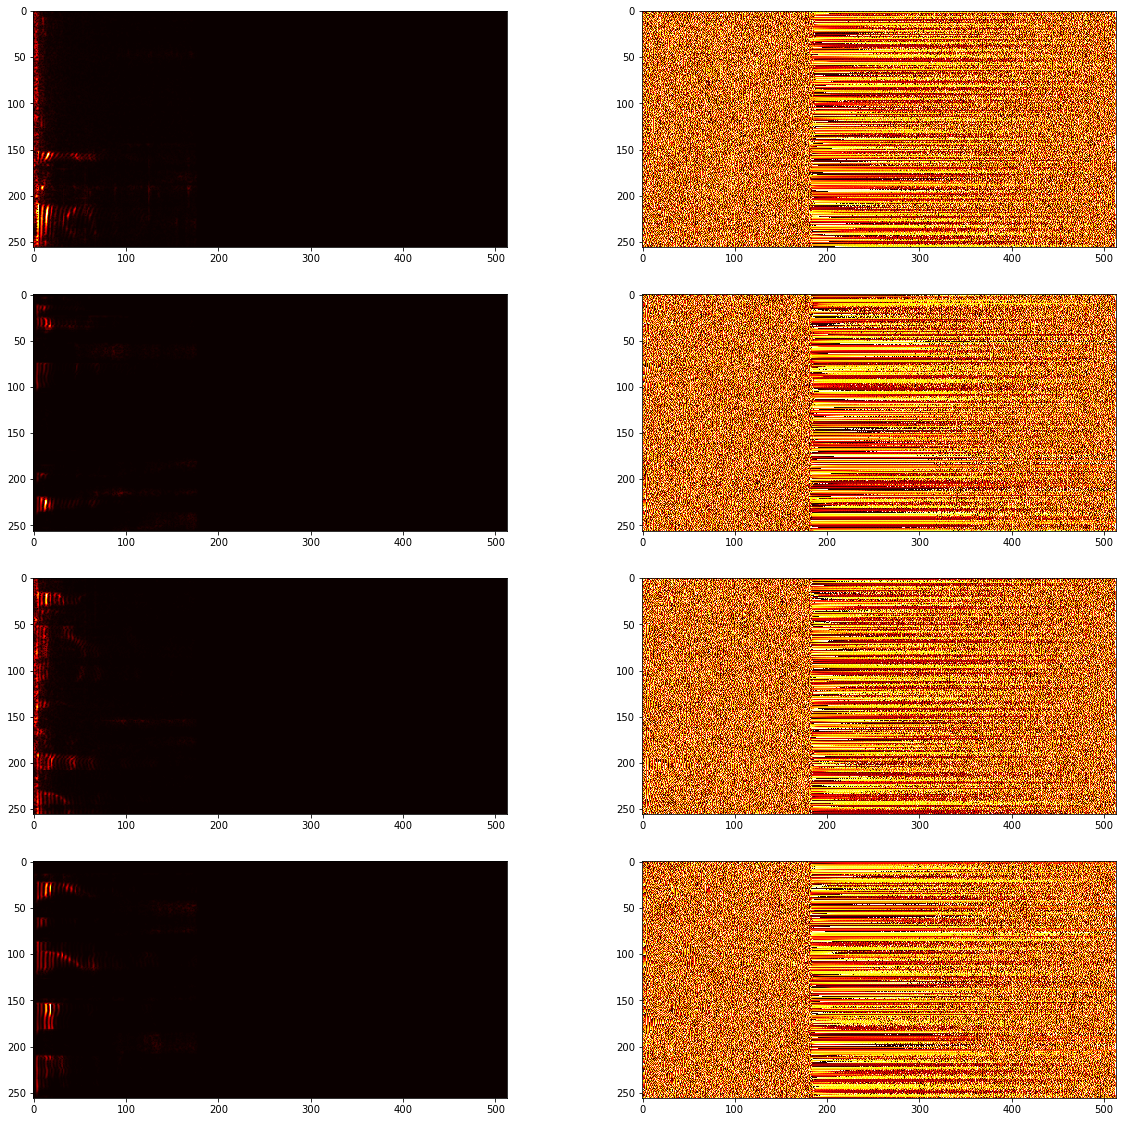

In [19]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(20,20))
ax1.imshow(m[0, :, :, 0])
ax2.imshow(m[0, :, :, 1])
ax3.imshow(v[0, :, :, 0])
ax4.imshow(v[0, :, :, 1])
ax5.imshow(m[2, :, :, 0])
ax6.imshow(m[2, :, :, 1])
ax7.imshow(v[2, :, :, 0])
ax8.imshow(v[2, :, :, 1])

## Training

Now that we have both the model and the data pipeline we can actually train a model.

In [20]:
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_mag = mixed[0][:, :, 1:, :2] # Yet more hacking to get around this tuple problem
mixed_phase = mixed[0][:, :, 1:, 2:]
voice_mag = voice[0][:, :, 1:, :2]

model = UNetModel(
    mixed_mag,
    voice_mag,
    mixed_phase,
    is_training
)

sess.run(tf.global_variables_initializer())

Predictions before training on a random batch from the training set:

In [21]:
single_mixed_batch, single_voice_batch = sess.run([mixed_mag, voice_mag])

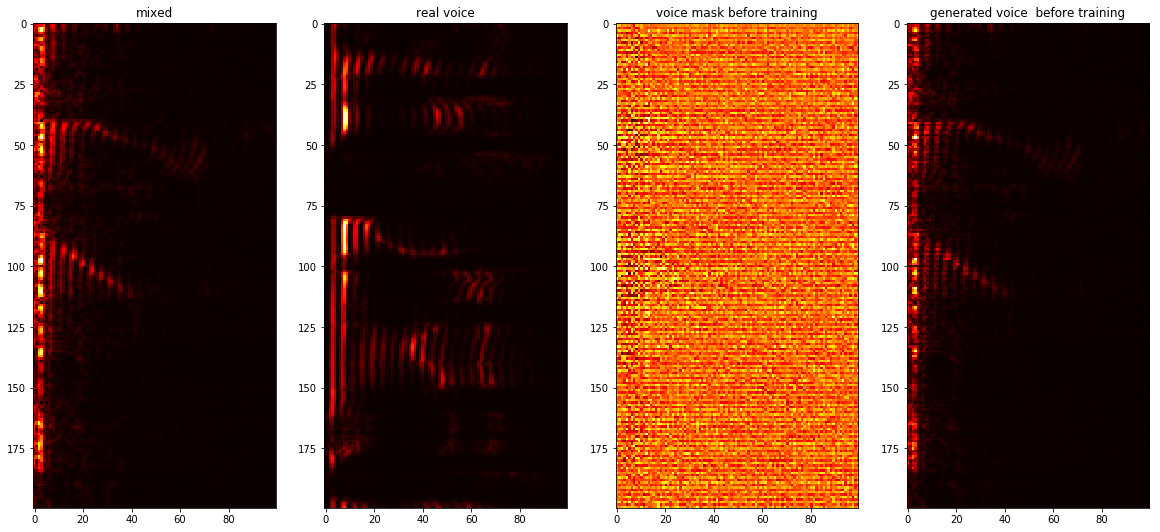

In [22]:
gen_voice, voice_mask = sess.run([model.gen_voice, model.voice_mask], {is_training: True, model.mixed: single_mixed_batch})
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,20))

ax1.imshow(single_mixed_batch[0, :200, :100, 0])
ax1.set_title('mixed')
ax2.imshow(single_voice_batch[0, :200, :100, 0])
ax2.set_title('real voice')
ax3.imshow(voice_mask[0, :200, :100, 0])
ax3.set_title('voice mask before training')
ax4.imshow(gen_voice[0, :200, :100, 0])
ax4.set_title('generated voice  before training')

Now let's train a small number of iterations.

In [27]:
for i in range(10):
    _, cost = sess.run([model.train_op, model.cost], {model.is_training: True})
    print("            , {0}, {1}".format(i, np.mean(cost))) #here we had code 'print "            ", i, cost', it was causing an error
                                                    #most likely related to python syntax changes in newer version

            , 0, 0.854095458984375
            , 1, 0.8619413375854492
            , 2, 0.8519009351730347
            , 3, 0.8551744222640991
            , 4, 0.8655912280082703
            , 5, 0.8473216891288757
            , 6, 0.8527441024780273
            , 7, 0.8545471429824829
            , 8, 0.8620553016662598
            , 9, 0.8548831939697266


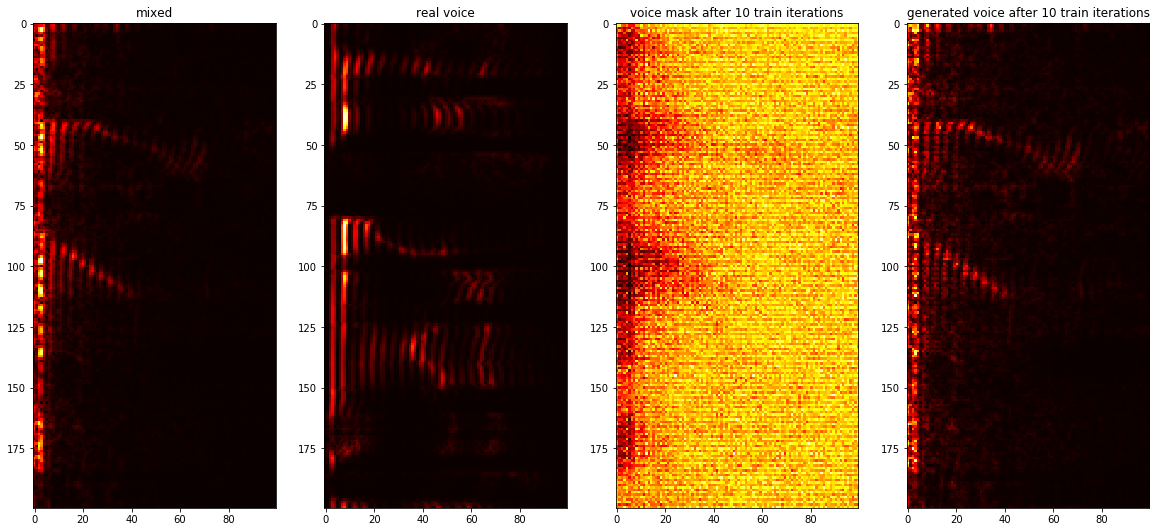

In [24]:
gen_voice, voice_mask = sess.run([model.gen_voice, model.voice_mask], {is_training: True, model.mixed: single_mixed_batch})
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,20))

ax1.imshow(single_mixed_batch[0, :200, :100, 0])
ax1.set_title('mixed')
ax2.imshow(single_voice_batch[0, :200, :100, 0])
ax2.set_title('real voice')
ax3.imshow(voice_mask[0, :200, :100, 0])
ax3.set_title('voice mask after 10 train iterations')
ax4.imshow(gen_voice[0, :200, :100, 0])
ax4.set_title('generated voice after 10 train iterations')

Let's train a little longer this time.

In [25]:
for i in range(100):
    _, cost = sess.run([model.train_op, model.cost], {model.is_training: True})
    if (i+1) % 100 == 0:
        print("            , {0}, {1}".format(i, np.mean(cost))) #same code from above 'print "            ", i, cost', was causing an error
print('Finished training {n} batches. Final cost: {c}'.format(n=i+1, c=np.mean(cost)))

            , 99, Tensor("Mean:0", shape=(), dtype=float32)
Finished training 100 batches. Final cost: Tensor("Mean_1:0", shape=(), dtype=float32)


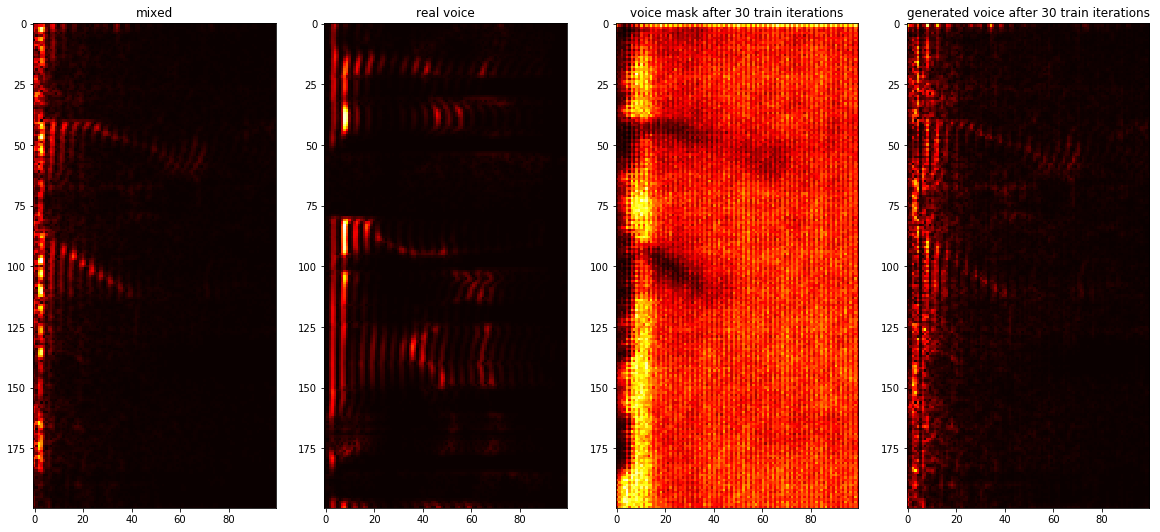

In [26]:
gen_voice, voice_mask = sess.run([model.gen_voice, model.voice_mask], {is_training: False, model.mixed: single_mixed_batch})
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,20))

ax1.imshow(single_mixed_batch[0, :200, :100, 0])
ax1.set_title('mixed')
ax2.imshow(single_voice_batch[0, :200, :100, 0])
ax2.set_title('real voice')
ax3.imshow(voice_mask[0, :200, :100, 0])
ax3.set_title('voice mask after 30 train iterations')
ax4.imshow(gen_voice[0, :200, :100, 0])
ax4.set_title('generated voice after 30 train iterations')

In [ ]:
audio_t = read_audio('C:/Users/Toby/Jupyter Notebooks/My Work/MSc Project/LDC2017S24.iso.wav', sample_rate=SAMPLE_RATE, n_channels=N_CHANNELS)

In [ ]:
spec_t = compute_spectrogram(audio_t, N_FFT, FFT_HOP, N_CHANNELS)

In [ ]:
patch_t = extract_spectrogram_patches(spec_t, N_FFT, N_CHANNELS, PATCH_WINDOW, PATCH_HOP)

In [ ]:
audio, spec, patch = sess.run([audio_t, spec_t, patch_t])

In [ ]:
print(spec.shape)
print(patch.shape)

In [ ]:
def plot_2D_audio(t, f, x, title, vmax=0.2):
    amp = 2 * np.sqrt(2)
    plt.pcolormesh(t, f, x, vmax=vmax)
    plt.title(title)
    plt.ylabel('Frequency')
    plt.xlabel('Time')
    plt.show()

In [ ]:
t = np.arange(spec.shape[0])
f = np.arange(spec.shape[1])
plot_2D_audio(t, f, spec[:,:,0].T, 'Spectrogram', vmax=0.5)

In [ ]:
t = np.arange(patch.shape[1])
f = np.arange(patch.shape[2])
plot_2D_audio(t, f,patch[2,:,:,0].T, 'Spectrogram Patch', vmax=0.5)

In [ ]:
def spectrogramToAudioFile(magnitude, fftWindowSize, hopSize, phaseIterations=10, phase=None, length=None):
    '''
    Computes an audio signal from the given magnitude spectrogram, and optionally an initial phase.
    Griffin-Lim is executed to recover/refine the given the phase from the magnitude spectrogram.
    :param magnitude: Magnitudes to be converted to audio
    :param fftWindowSize: Size of FFT window used to create magnitudes
    :param hopSize: Hop size in frames used to create magnitudes
    :param phaseIterations: Number of Griffin-Lim iterations to recover phase
    :param phase: If given, starts ISTFT with this particular phase matrix
    :param length: If given, audio signal is clipped/padded to this number of frames
    :return: 
    '''
    if phase is not None:
        if phaseIterations > 0:
            # Refine audio given initial phase with a number of iterations
            return reconPhase(magnitude, fftWindowSize, hopSize, phaseIterations, phase, length)
        # reconstructing the new complex matrix
        stftMatrix = magnitude * np.exp(phase * 1j) # magnitude * e^(j*phase)
        audio = librosa.istft(stftMatrix, hop_length=hopSize, length=length)
    else:
        audio = reconPhase(magnitude, fftWindowSize, hopSize, phaseIterations)
    return audio

def reconPhase(magnitude, fftWindowSize, hopSize, phaseIterations=10, initPhase=None, length=None):
    '''
    Griffin-Lim algorithm for reconstructing the phase for a given magnitude spectrogram, optionally with a given
    intial phase.
    :param magnitude: Magnitudes to be converted to audio
    :param fftWindowSize: Size of FFT window used to create magnitudes
    :param hopSize: Hop size in frames used to create magnitudes
    :param phaseIterations: Number of Griffin-Lim iterations to recover phase
    :param initPhase: If given, starts reconstruction with this particular phase matrix
    :param length: If given, audio signal is clipped/padded to this number of frames
    :return: 
    '''
    for i in range(phaseIterations):
        if i == 0:
            if initPhase is None:
                reconstruction = np.random.random_sample(magnitude.shape) + 1j * (2 * np.pi * np.random.random_sample(magnitude.shape) - np.pi)
            else:
                reconstruction = np.exp(initPhase * 1j) # e^(j*phase), so that angle => phase
        else:
            reconstruction = librosa.stft(audio, fftWindowSize, hopSize)
        spectrum = magnitude * np.exp(1j * np.angle(reconstruction))
        if i == phaseIterations - 1:
            audio = librosa.istft(spectrum, hopSize, length=length)
        else:
            audio = librosa.istft(spectrum, hopSize)
    return audio

In [ ]:
sess = tf.Session()

path = 'C:/Users/Toby/MSc_Project/Test_Audio/GANdatasetsMini/train_sup/Mixed/F01_22GC010A_BUS.CH1.wav'

audio_tensor = read_audio(path, 44100, 1)
spec_tensor = compute_spectrogram(audio_tensor, N_FFT, FFT_HOP, N_CHANNELS)
spec, audio = sess.run([spec_tensor, audio_tensor])
print('Original audio shape: ', audio.shape)
print('Spectrogram shape: ', spec.shape)


# Split out the magnitude and phase
mag = spec[:,:,0]
phase = spec[:,:,1]
print('Magnitude shape: ', mag.shape)
print('Phase shape: ', phase.shape)

# Now reconstruct the audio from magnitude and phase
new_audio = spectrogramToAudioFile(mag.T, N_FFT, FFT_HOP, phaseIterations=0, phase=phase.T)
print('Reconstructed audio shape: ', new_audio.shape)

# plot the original wave form with the reconstructed one
x0 = np.arange(audio.shape[0])
x1 = np.arange(new_audio.shape[0])
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(x0,audio)
ax[0].set_title('Original Waveform')
ax[1].plot(x1,new_audio)
ax[1].set_title('Reconstructed Waveform')
ax[1].set_xlabel('Time [samples]')


In [ ]:
np.expand_dims(new_audio,1).T.shape

In [1]:
import re

In [2]:
filename = 'F01_22GC010A_BTH.CH1.wav'

In [3]:
if re.search('CH0',filename):
    print('TRUE!')
else:
    print('FALSE!')

FALSE!


In [4]:
if re.search('^((?!CH0).)*$',filename):
    print('TRUE!')
else:
    print('FALSE!')

TRUE!


In [5]:
test_list = ['CH1', 'CH3', 'CH0']

In [7]:
list(filter(lambda x: re.search('^((?!CH0).)*$',x), test_list))

['CH1', 'CH3']

In [ ]:
res

In [ ]:
nums = [0,1,2,3,4]
res = list(filter(lambda x: x>2, nums))
print(res)

In [ ]:
number_list = range(-5, 5)
less_than_zero = list(filter(lambda x: x < 0, number_list))
print(less_than_zero)

# Output: [-5, -4, -3, -2, -1]

In [8]:
import tensorflow as tf

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
data_folder = 'C:/Users/Toby/MSc_Project/Test_Audio/GANdatasetsMini/train_sup/Voice'
dataset = tf.data.Dataset.list_files(data_folder + '/*.wav')


In [25]:
tf.reset_default_graph()

In [1]:
from Main import ex

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
r = ex.run()

INFO - UNet_Speech_Separation - Running command 'do_experiment'
INFO - UNet_Speech_Separation - Started run with ID "8"


Preparing dataset
Creating model
Running initialisation test
Starting testing


C:\Program Files\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Testing complete. Mean results over test set:
Loss: 0.28623372316360474
SDR:  -5.765735672649822
SIR:  inf
SAR:  -5.765735672649822
Starting training
Epoch 1 finished.
Validating
Validation check mean loss: 0.23105376958847046
Validation loss has improved!
Finished requested number of epochs. Training complete.
Best validation loss: 0.23105376958847046
Checkpoint
Starting testing


INFO - UNet_Speech_Separation - Completed after 0:01:20


Testing complete. Mean results over test set:
Loss: 0.2952589988708496
SDR:  -6.633871603900573
SIR:  inf
SAR:  -6.633871603900573
All done!
Initial test loss: 0.28623372316360474
Final test loss: 0.2952589988708496


In [2]:
sess = tf.Session()

In [3]:
checkpoint = 'C:/Users/Toby/MSc_Project/MScFinalProjectCheckpoints/84569/84569-16'
restorer = tf.train.import_meta_graph(checkpoint+'.meta')
restorer.restore(sess, checkpoint)

INFO:tensorflow:Restoring parameters from C:/Users/Toby/MSc_Project/MScFinalProjectCheckpoints/84569/84569-16


In [19]:
model = sess.run('U_Net_Model/')

ValueError: Fetch argument 'U_Net_Model/' cannot be interpreted as a Tensor. ("The name 'U_Net_Model/' refers to an Operation not in the graph.")

In [20]:
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file

# List ALL tensors.
print_tensors_in_checkpoint_file(file_name='C:/Users/Toby/MSc_Project/MScFinalProjectCheckpoints/314463/314463-9', tensor_name='', all_tensors='')

U_Net_Model/U_Net_Model/voice-mask-unet/decoder/layer-1/BatchNorm/beta/Adam (DT_FLOAT) [256]
U_Net_Model/U_Net_Model/voice-mask-unet/decoder/layer-1/BatchNorm/beta/Adam_1 (DT_FLOAT) [256]
U_Net_Model/U_Net_Model/voice-mask-unet/decoder/layer-1/BatchNorm/gamma/Adam (DT_FLOAT) [256]
U_Net_Model/U_Net_Model/voice-mask-unet/decoder/layer-1/BatchNorm/gamma/Adam_1 (DT_FLOAT) [256]
U_Net_Model/U_Net_Model/voice-mask-unet/decoder/layer-1/conv2d_transpose/bias/Adam (DT_FLOAT) [256]
U_Net_Model/U_Net_Model/voice-mask-unet/decoder/layer-1/conv2d_transpose/bias/Adam_1 (DT_FLOAT) [256]
U_Net_Model/U_Net_Model/voice-mask-unet/decoder/layer-1/conv2d_transpose/kernel/Adam (DT_FLOAT) [5,5,256,512]
U_Net_Model/U_Net_Model/voice-mask-unet/decoder/layer-1/conv2d_transpose/kernel/Adam_1 (DT_FLOAT) [5,5,256,512]
U_Net_Model/U_Net_Model/voice-mask-unet/decoder/layer-2/BatchNorm/beta/Adam (DT_FLOAT) [128]
U_Net_Model/U_Net_Model/voice-mask-unet/decoder/layer-2/BatchNorm/beta/Adam_1 (DT_FLOAT) [128]
U_Net_Mode

In [1]:
import os

In [5]:
os.path.join(os.getcwd(),'..')

'C:\\Users\\Toby\\MSc_Project\\MScFinalProject\\..'

In [6]:
import sys

In [7]:
print(sys.version)

3.6.1 |Anaconda custom (64-bit)| (default, May 11 2017, 13:25:24) [MSC v.1900 64 bit (AMD64)]


In [7]:
import re

In [35]:
data_folder = 'C:/Users/Toby/MSc_Project/Test_Audio/GANdatasetsMini/train_sup/Voice'
test_data = tf.data.Dataset.list_files(data_folder + '/*.wav',shuffle=False).filter(lambda x: re.search('CH0', str(x)) is None)

In [36]:
sess = tf.Session()
iterator = test_data.make_one_shot_iterator()
first_item = iterator.get_next()
print(sess.run(first_item))

b'C:\\Users\\Toby\\MSc_Project\\Test_Audio\\GANdatasetsMini\\train_sup\\Voice\\F01_22GC0104_BTH.CH1.wav'


In [37]:
other_data_folder = 'C:/Users/Toby/MSc_Project/Test_Audio/GANdatasetsMini/train_sup/Mixed'
other_test_data = tf.data.Dataset.list_files(other_data_folder + '/*.wav',shuffle=False).filter(lambda x: re.search('CH0', str(x)) is None)

In [38]:
other_iterator = other_test_data.make_one_shot_iterator()
other_first_item = other_iterator.get_next()
print(sess.run(other_first_item))

b'C:\\Users\\Toby\\MSc_Project\\Test_Audio\\GANdatasetsMini\\train_sup\\Mixed\\F01_22GC0104_BUS.CH1.wav'


In [39]:
print(sess.run(first_item))
print(sess.run(other_first_item))

b'C:\\Users\\Toby\\MSc_Project\\Test_Audio\\GANdatasetsMini\\train_sup\\Voice\\F01_22GC0104_BTH.CH2.wav'
b'C:\\Users\\Toby\\MSc_Project\\Test_Audio\\GANdatasetsMini\\train_sup\\Mixed\\F01_22GC0104_BUS.CH2.wav'


In [40]:
print(sess.run(first_item))
print(sess.run(other_first_item))

b'C:\\Users\\Toby\\MSc_Project\\Test_Audio\\GANdatasetsMini\\train_sup\\Voice\\F01_22GC0104_BTH.CH3.wav'
b'C:\\Users\\Toby\\MSc_Project\\Test_Audio\\GANdatasetsMini\\train_sup\\Mixed\\F01_22GC0104_BUS.CH3.wav'
